# Introdução a NLP

## Coletando dados

Todo problema em ML começa com dados, como uma lista de e-mails, postagens em redes sociais ou chats. Algumas fontes são comuns:

* Revisão de produtos (Amazon, Yelp e App Stores);
* Conteúdo gerado por usuários (Tweets, Facebook e StackOverflow);
* Solução de problemas (solicitação de clientes, abertura de chamados, informações de bate-papo).
* Os dados utilizados neste guia, são dados disponibilizados pela Figure Eight (https://www.figure-eight.com/). O conjunto de dados é chamado de “Disasters on Social Media” e possui mais de 10.000 tweets que foram selecionados a partir de buscas envolvendo chaves como “em chamas”, “quarentena” e “pandemônio”, relacionando posteriormente o resultado dessas buscas com eventos realmente desastrosos e não desastrosos.A tarefa a ser realizada nestes dados, é identificar um tweet realmente relevante em relação a um desastre. Uma aplicação para a solução que será desenvolvida aqui, em potencial, seria avisar aos bombeiros sobre um desastre que realmente está acontecendo de rapidamente. No entanto, realizar este procedimento contornando uma publicação referente a um filme de ação, por exemplo, que pode conter as mesmas palavras chaves relacionadas com um desatre.A seguir a importação das bibliotecas úteis para o desenvolvimento do guia.

In [ ]:
import keras
import nltk
import pandas as pd
import numpy as np
import re
import codecs
import itertools
import matplotlib
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
import numpy as np
import gensim
import keras
import nltk
import pandas as pd
import numpy as np
import re
import codecs
import itertools
import matplotlib
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
import numpy as np
import gensim 

## Limpando os dados

O primeiro passo é saber examinar os dados para, posteriormente, limpá-los. Um conjunto de dados limpo permitirá que um modelo aprenda apenas recursos significativamente relevantes e não se adeque a ruídos. Ruídos são características do texto que não são significativos para caracterizar o que se pretende avaliar. No exemplo dos tweets, a hashtag (#) usada para compor determinadas palavras em nada caracteriza o texto propriamente dito. Outras características  que precisam ser consideradas na limpeza dos dados são:

* Remover caracteres irrelevantes como os não alfanuméricos;
* Remover palavras que não são relevantes, como as menções indicadas com “@”;
* Converter termos para minúsculos, homogeneizando os dados (OLÁ – olá);
* Combinar palavras escritas incorretamente para uma única representação (legaaalll – legal);
* Considerar lematização (reduzir palavras como “sou”, “é” para uma forma desflexionada como “ser”);
* Quebrar o seu texto em termos.


Após considerar as opções de limpeza acima, é possível começar a usar os dados para treinar um modelo de predição.

A seguir o código de limpeza dos dados que, na sequência, serão utilizados para treinar o modelo.

In [ ]:
# Limpando dataset
input_file = codecs.open("socialmedia_relevant_cols.csv", "r",encoding='utf-8', errors='replace')
output_file = open("socialmedia_relevant_cols_clean.csv", "w")

def sanitize_characters(raw, clean):    
    for line in input_file:
        out = line
        output_file.write(line)
sanitize_characters(input_file, output_file)

In [ ]:
# Inspecionando os dados 
questions = pd.read_csv("socialmedia_relevant_cols_clean.csv") 
questions.columns=['text', 'choose_one', 'class_label']

**Dados sujos:**

In [ ]:
#Primeiras linhas 
questions.head()

,text,choose_one,class_label
0,Just happened a terrible car crash,Relevant,1
1,Our Deeds are the Reason of this #earthquake M...,Relevant,1
2,"Heard about #earthquake is different cities, s...",Relevant,1
3,"there is a forest fire at spot pond, geese are...",Relevant,1
4,Forest fire near La Ronge Sask. Canada,Relevant,1


**Tabela 1:**

In [ ]:
#Últimas linhas 
questions.tail()

,text,choose_one,class_label
10854,1.3 #Earthquake in 9Km Ssw Of Anza California ...,Relevant,1
10855,Evacuation order lifted for town of Roosevelt:...,Relevant,1
10856,See the 16yr old PKK suicide bomber who detona...,Relevant,1
10857,To conference attendees! The blue line from th...,Relevant,1
10858,The death toll in a #IS-suicide car bombing on...,Relevant,1


In [ ]:
# Estatística descritiva
questions.describe()

,class_label
count,10859.000000
mean,0.431808
std,0.498317
min,0.000000
25%,0.000000
50%,0.000000
75%,1.000000
max,2.000000


**Método de limpeza:**

In [ ]:
# Expressões regulares para limpeza dos dados 
def standardize_text(df, text_field):    
    df[text_field] = df[text_field].str.replace(r"http\S+", "")    
    df[text_field] = df[text_field].str.replace(r"http", "")    
    df[text_field] = df[text_field].str.replace(r"@\S+", "")    
    df[text_field] = df[text_field].str.replace(r"[^A-Za-z0-9(),!?@\'\`\"\_\n]", " ")    
    df[text_field] = df[text_field].str.replace(r"@", "at")    
    df[text_field] = df[text_field].str.lower()    
    return df

In [ ]:
#Limpeza e regravação do arquivo de saída limpo 
clean_questions = standardize_text(questions, "text") 
clean_questions.to_csv("clean_data.csv")

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: FutureWarning: The default value of regex will change from True to False in a future version.
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: FutureWarning: The default value of regex will change from True to False in a future version.
  """
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: FutureWarning: The default value of regex will change from True to False in a future version.
  


**Dados limpos:**

In [ ]:
#Primeiras linhas 
clean_questions.head()

,text,choose_one,class_label
0,just happened a terrible car crash,Relevant,1
1,our deeds are the reason of this earthquake m...,Relevant,1
2,"heard about earthquake is different cities, s...",Relevant,1
3,"there is a forest fire at spot pond, geese are...",Relevant,1
4,forest fire near la ronge sask canada,Relevant,1


In [ ]:
#Últimas linhas 
clean_questions.tail()

,text,choose_one,class_label
10854,1 3 earthquake in 9km ssw of anza california ...,Relevant,1
10855,evacuation order lifted for town of roosevelt,Relevant,1
10856,see the 16yr old pkk suicide bomber who detona...,Relevant,1
10857,to conference attendees! the blue line from th...,Relevant,1
10858,the death toll in a is suicide car bombing on...,Relevant,1


**Distribuição das classes:**

In [ ]:
clean_questions.groupby("class_label").count()

,text,choose_one
class_label,,
0,6186,6186
1,4657,4657
2,16,16


É possível observar que os dados apresentam leve desbalanceamento, com elevação da classe “Not Relevant”.

## Quebrando os dados

Agora que temos os dados limpos, vamos transformá-los para que o modelo possa entender. Logo:

* Quebrar as sentenças em listas de palavras separadas;
* Dividir os dados para treinamento e teste do modelo;
* Inspecionar os dados novamente.

In [ ]:
from nltk.tokenize import RegexpTokenizer 
# Método de quebra dos dados 
tokenizer = RegexpTokenizer(r'\w+') 
# Gerando listas de sentenças quebradas 
clean_questions["tokens"] = clean_questions["text"].apply(tokenizer.tokenize)

In [ ]:
#Primeiras linhas 
clean_questions.head()

,text,choose_one,class_label,tokens
0,just happened a terrible car crash,Relevant,1,"[just, happened, a, terrible, car, crash]"
1,our deeds are the reason of this earthquake m...,Relevant,1,"[our, deeds, are, the, reason, of, this, earth..."
2,"heard about earthquake is different cities, s...",Relevant,1,"[heard, about, earthquake, is, different, citi..."
3,"there is a forest fire at spot pond, geese are...",Relevant,1,"[there, is, a, forest, fire, at, spot, pond, g..."
4,forest fire near la ronge sask canada,Relevant,1,"[forest, fire, near, la, ronge, sask, canada]"


In [ ]:
#Últimas linhas 
clean_questions.tail()

,text,choose_one,class_label,tokens
10854,1 3 earthquake in 9km ssw of anza california ...,Relevant,1,"[1, 3, earthquake, in, 9km, ssw, of, anza, cal..."
10855,evacuation order lifted for town of roosevelt,Relevant,1,"[evacuation, order, lifted, for, town, of, roo..."
10856,see the 16yr old pkk suicide bomber who detona...,Relevant,1,"[see, the, 16yr, old, pkk, suicide, bomber, wh..."
10857,to conference attendees! the blue line from th...,Relevant,1,"[to, conference, attendees, the, blue, line, f..."
10858,the death toll in a is suicide car bombing on...,Relevant,1,"[the, death, toll, in, a, is, suicide, car, bo..."


In [ ]:
#Inspecioanndo novamente os dados 
all_words = [word for tokens in clean_questions["tokens"] for word in tokens] 
sentence_lengths = [len(tokens) for tokens in clean_questions["tokens"]] 
VOCAB = sorted(list(set(all_words))) 
print("%s Quantidade total de palavras, com um vocabulario de %s" % (len(all_words), len(VOCAB)))
print("Tamanho máximo de uma sentença %s" % max(sentence_lengths))

154484 Quantidade total de palavras, com um vocabulario de 18095
Tamanho máximo de uma sentença 34


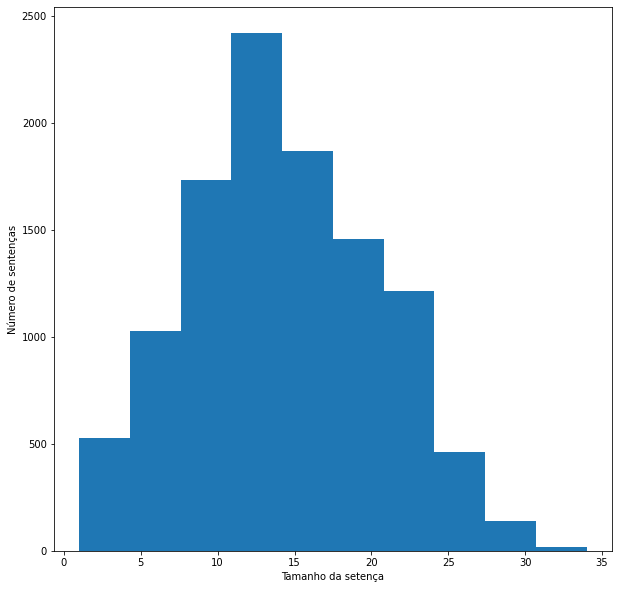

In [ ]:
#Distribuilção das sentenças por quantidade de palavras 
fig = plt.figure(figsize=(10, 10)) 
plt.xlabel('Tamanho da setença') 
plt.ylabel('Número de sentenças') 
plt.hist(sentence_lengths) 
plt.show()

podemos observar que a distribuição no tamanho das sentenças tende a normalidade. Essa característica é importante para evitar viés no processo de classificação quanto ao tamanho dos textos avaliados e a quantidade de palavras específicas em uma determinada sentença.

# NLP e ML

## Count Vectorizer

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

# Construindo bag-of-words com count-vectorizer 
count_vectorizer = CountVectorizer() 
# Separando o texto da variável alvo 
list_corpus = clean_questions["text"].tolist() 
list_labels = clean_questions["class_label"].tolist() 
# Construindo exemplos para treinamento e teste 
X_train, X_test, y_train, y_test = train_test_split(list_corpus, list_labels, test_size=0.2, random_state=40)                                                           
# Aprendendo o vacabulário e contabilizando os termos para teste 
X_train_counts = count_vectorizer.fit_transform(X_train) 
# Contabilizando os termos no vocabulário aprendido para treino 
X_test_counts = count_vectorizer.transform(X_test)

## Visualizando o Vocabulário

Agora que já criamos o vocabulário para treinar o modelo, vamos tentar identificar algum tipo de estrutura semelhante ou agrupamento baseado na variável alvo. No mundo real perfeito, nosso vocabulário seria tão distinto considerando a variável alvo, que estariam distribuidos perfeitamente em grupos separados. A projeção será feita em duas dimensões (LSA).

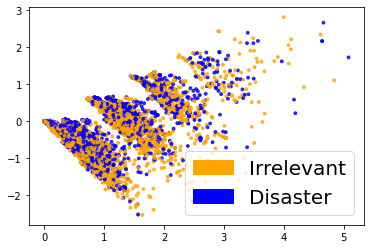

<Figure size 720x720 with 0 Axes>

In [ ]:
from sklearn.decomposition import PCA, TruncatedSVD

# Método para plotar o gráfico com a distribuição do vocabulário por variável alvo 
def plot_LSA(test_data, test_labels, savepath="PCA_demo.csv", plot=True):
        lsa = TruncatedSVD(n_components=2)        
        lsa.fit(test_data)        
        lsa_scores = lsa.transform(test_data)        
        color_mapper = {label:idx for idx,label in enumerate(set(test_labels))}        
        color_column = [color_mapper[label] for label in test_labels]        
        colors = ['orange','blue','blue']        
        if plot:            
           plt.scatter(lsa_scores[:,0], lsa_scores[:,1], s=8, alpha=.8, c=test_labels, cmap=matplotlib.colors.ListedColormap(colors))
           red_patch = mpatches.Patch(color='orange', label='Irrelevant')            
           green_patch = mpatches.Patch(color='blue', label='Disaster')           
           plt.legend(handles=[red_patch, green_patch], prop={'size': 20})            
           
           return plt

plt_ = plot_LSA(X_train_counts, y_train)
fig = plt.figure(figsize=(10, 10))          
plt.show()

## Treinando o Classificador

Iniciar com uma regressão logística, visto que, é simples, e muitas vezes resolve o problema. Além disso, é fácil de interpretar.

In [ ]:
from sklearn.linear_model import LogisticRegression

# Aplicando configurações no modelo 
clf = LogisticRegression(C=30.0, class_weight='balanced', solver='newton-cg',multi_class='multinomial', n_jobs=-1, random_state=40) 
#Treinando o modelo com o vocabulário construindo e as variáveis alvo 
clf.fit(X_train_counts, y_train) 
#Realizando as predições para o conjunto de teste 
y_predicted_counts = clf.predict(X_test_counts)

## Avaliando o Classificador

Agora vamos obervar e avaliar algumas métricas para identificar se nosso classificador apresentou um bom desempenho. Para isso, usaremos métricas comumente utilizadas para avaliação de preditores (precisão, cobertura e medida-f).

In [ ]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report

# Método para extração das métricas de avaliação usando a parte dos dados que separamos para teste. 
def get_metrics(y_test, y_predicted):      
   # true positives / (true positives+false positives)    
   precision = precision_score(y_test, y_predicted, pos_label=None,average='weighted')                 
   # true positives / (true positives + false negatives)    
   recall = recall_score(y_test, y_predicted, pos_label=None,average='weighted')        
   # harmonic mean of precision and recall    
   f1 = f1_score(y_test, y_predicted, pos_label=None, average='weighted')        
   # true positives + true negatives/ total    
   accuracy = accuracy_score(y_test, y_predicted)    
   return accuracy, precision, recall, f1 

accuracy, precision, recall, f1 = get_metrics(y_test, y_predicted_counts) 
print("accuracy = %.3f, precision = %.3f, recall = %.3f, f1 = %.3f" % (accuracy, precision, recall, f1))

accuracy = 0.761, precision = 0.758, recall = 0.761, f1 = 0.759


Um classificador muito bom apresentaria métricas próximas de 1. Logo, para que se aproxime de 1 ou seja exatamente 1, a quantidade de falsos-positivos e falsos-negativos deve ser 0. Avaliando as métricas que extraímos, podemos observar que estamos longe disso.

Para analisar especificamente os erros, usaremos outra abordagem bastante conhecido no meio: a matriz de confusão.

In [ ]:
from sklearn.metrics import confusion_matrix

#Método para plotar a matriz de confusão. 
def plot_confusion_matrix(cm, classes,normalize=False, title='Confusion matrix', cmap=plt.cm.winter): 
    if normalize:        
       cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]    
    plt.imshow(cm, interpolation='nearest', cmap=cmap)    
    plt.title(title, fontsize=30)    
    plt.colorbar()    
    tick_marks = np.arange(len(classes))    
    plt.xticks(tick_marks, classes, fontsize=20)    
    plt.yticks(tick_marks, classes, fontsize=20)        
    fmt = '.2f' if normalize else 'd'    
    thresh = cm.max() / 2.     
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):        
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center",color="white" if cm[i, j] < thresh else "black", fontsize=40)
    
    plt.tight_layout()   
    plt.ylabel('True label', fontsize=30)    
    plt.xlabel('Predicted label', fontsize=30)     
   
    return plt

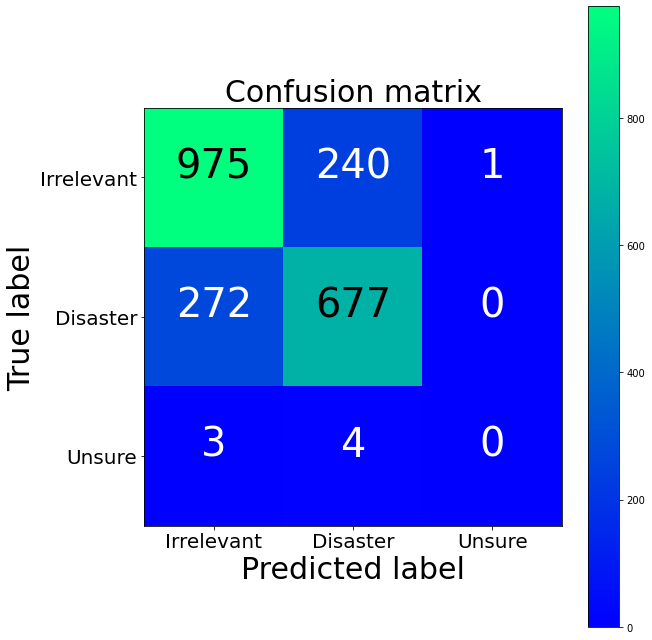

Count Vectorizer confusion matrix
[[975 240   1]
 [272 677   0]
 [  3   4   0]]


In [ ]:
cm = confusion_matrix(y_test, y_predicted_counts) 
fig = plt.figure(figsize=(9, 9)) 
plot = plot_confusion_matrix(cm, classes=['Irrelevant','Disaster','Unsure'], normalize=False, title='Confusion matrix') 
plt.show() 
print("Count Vectorizer confusion matrix") 
print(cm)

Vamos realizar uma inspeção adicional para entender quais features (palavras) estão sendo usadas pelo classificador para tomada de decisão.

In [ ]:
# Método para identificação das features mais importantes na tomada de decisão. 
def get_most_important_features(vectorizer, model, n=5):    
    index_to_word = {v:k for k,v in vectorizer.vocabulary_.items()}        
    # loop for each class    
    classes ={}    
    for class_index in range(model.coef_.shape[0]):        
        word_importances = [(el, index_to_word[i]) for i,el in enumerate(model.coef_[class_index])]        
        sorted_coeff = sorted(word_importances, key = lambda x : x[0], reverse=True)        
        tops = sorted(sorted_coeff[:n], key = lambda x : x[0])        
        bottom = sorted_coeff[-n:]        
        classes[class_index] = {'tops':tops,'bottom':bottom}    
    return classes 

importance = get_most_important_features(count_vectorizer, clf, 10)

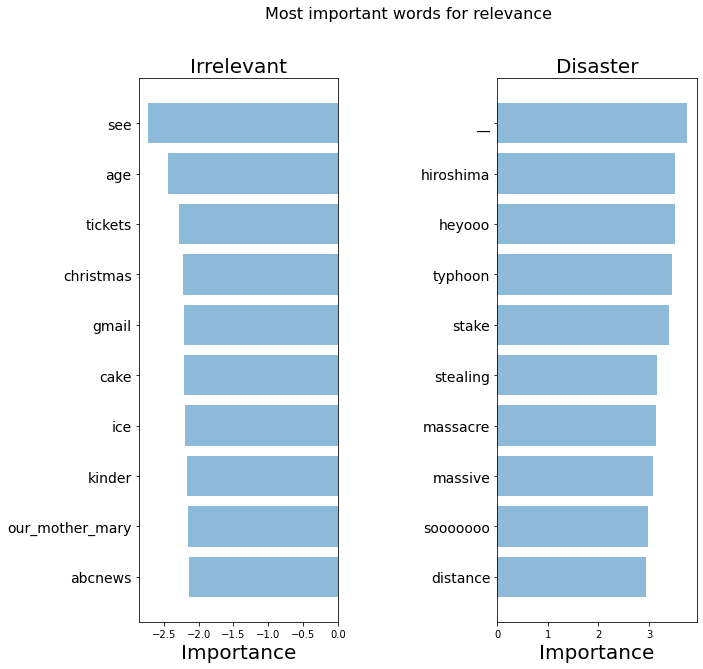

In [ ]:
# Método para plotar as featrues mais importantes para cada variável alvo. 
def plot_important_words(top_scores, top_words, bottom_scores, bottom_words, name):    
    y_pos = np.arange(len(top_words))    
    top_pairs = [(a,b) for a,b in zip(top_words, top_scores)]    
    top_pairs = sorted(top_pairs, key=lambda x: x[1])        
    bottom_pairs = [(a,b) for a,b in zip(bottom_words, bottom_scores)]    
    bottom_pairs = sorted(bottom_pairs, key=lambda x: x[1], reverse=True)        
    top_words = [a[0] for a in top_pairs]    
    top_scores = [a[1] for a in top_pairs]        
    bottom_words = [a[0] for a in bottom_pairs]    
    bottom_scores = [a[1] for a in bottom_pairs]        
    fig = plt.figure(figsize=(10, 10))      
    plt.subplot(121)    
    plt.barh(y_pos,bottom_scores, align='center', alpha=0.5)    
    plt.title('Irrelevant', fontsize=20)    
    plt.yticks(y_pos, bottom_words, fontsize=14)    
    plt.suptitle('Key words', fontsize=16)    
    plt.xlabel('Importance', fontsize=20)        
    plt.subplot(122)    
    plt.barh(y_pos,top_scores, align='center', alpha=0.5)    
    plt.title('Disaster', fontsize=20)    
    plt.yticks(y_pos, top_words, fontsize=14)    
    plt.suptitle(name, fontsize=16)    
    plt.xlabel('Importance', fontsize=20)        
    plt.subplots_adjust(wspace=0.8)    
    plt.show()
    
top_scores = [a[0] for a in importance[1]['tops']] 
top_words = [a[1] for a in importance[1]['tops']] 
bottom_scores = [a[0] for a in importance[1]['bottom']] 
bottom_words = [a[1] for a in importance[1]['bottom']] 
plot_important_words(top_scores, top_words, bottom_scores, bottom_words, "Most important words for relevance")

Podemos observar que nosso classificador capta alguns padrões realmente relevantes e relacionados com desastres e não desastres (ex. hiroshima e descarrilhamento). No entanto, parece estar aprendendo termos irrelevantes para discriminar os fatos (ex. x1392 e heyooo). Esses termos são tratados como ruídos e, quando se aprende ruídos, identificamos o que chamamos de overfitting (super ajuste do modelo).

## TF-IDF Bag of Words

Nesta seção vamos trabalhar com uma abordagem para construção da mala de palavras (bag-of-words) de uma forma mais refinada. Nós iremos usar agora a abordagem TF-IDF (Term Frequency, Inverse Document Frequency), essa abordagem não realiza apenas a contabilização dos termos, unicamente, pela quantidade de vezes em que ele aparece, mas também leva em consideração em quantos textos ele aparece individualmente.

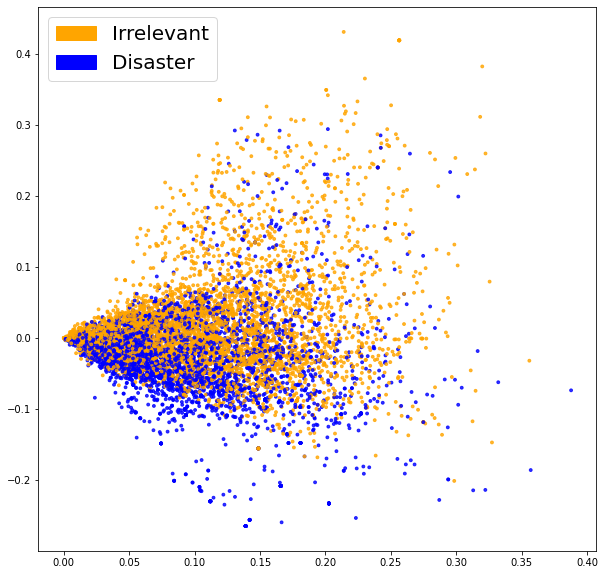

In [ ]:
# Construindo bag-of-words com count-vectorizer 
tfidf_vectorizer = TfidfVectorizer() 
# Aprendendo o vacabulário e contabilizando os termos para teste 
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train) 
# Contabilizando os termos no vocabulário aprendido para treino 
X_test_tfidf = tfidf_vectorizer.transform(X_test) 
# Plotando a distribuição do vocabulário 
fig = plt.figure(figsize=(10, 10))          
plt__ = plot_LSA(X_train_tfidf, y_train) 
plt.show()

Obervando o gráfico acima, podemos perceber que a nova abordagem agrupou os dados melhor que a abordagem anterior. 

In [ ]:
clf_tfidf = LogisticRegression(C=30.0, class_weight='balanced', solver='newton-cg',                          multi_class='multinomial', n_jobs=-1, random_state=40) 
#Treinando o modelo com o vocabulário construindo e as variáveis alvo 
clf_tfidf.fit(X_train_tfidf, y_train) 
y_predicted_tfidf = clf_tfidf.predict(X_test_tfidf)

In [ ]:
accuracy_tfidf, precision_tfidf, recall_tfidf, f1_tfidf = get_metrics(y_test, y_predicted_tfidf) 
print("accuracy = %.3f, precision = %.3f, recall = %.3f, f1 = %.3f" % (accuracy_tfidf, precision_tfidf,recall_tfidf, f1_tfidf))

accuracy = 0.760, precision = 0.757, recall = 0.760, f1 = 0.758


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


omparando os novos resultados obtidos, por meio da abordagem para contagem de termos TF-IDF, podemos obervar que obtivemos uma pequena melhora na capacidade de predição do modelo considerando as métricas: precisão, cobertura e medida-f.

Vamos analisar a matriz de confusão e entender como os erros estão acontecendo.

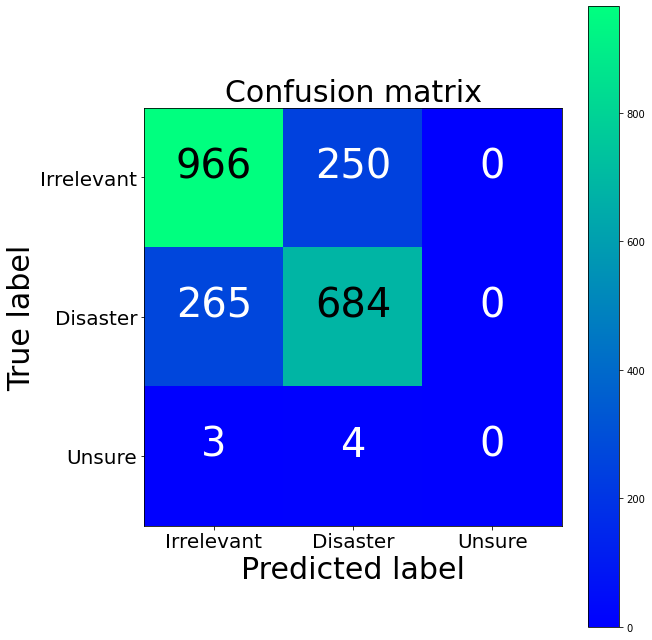

TFIDF confusion matrix
[[966 250   0]
 [265 684   0]
 [  3   4   0]]
BoW confusion matrix
[[975 240   1]
 [272 677   0]
 [  3   4   0]]


In [ ]:
cm2 = confusion_matrix(y_test, y_predicted_tfidf) 
fig = plt.figure(figsize=(9, 9)) 
plot = plot_confusion_matrix(cm2, classes=['Irrelevant','Disaster','Unsure'], normalize=False, title='Confusion matrix') 
plt.show() 
print("TFIDF confusion matrix") 
print(cm2)
print("BoW confusion matrix") 
print(cm)

 Podemos observar que tivemos uma redução na quantidade de falsos-positivos e falsos-negativos.

Vamos obervar quais palavras foram consideradas mais importantes para tomada de decisão do novo classificador.

In [ ]:
importance_tfidf = get_most_important_features(tfidf_vectorizer, clf_tfidf, 10)

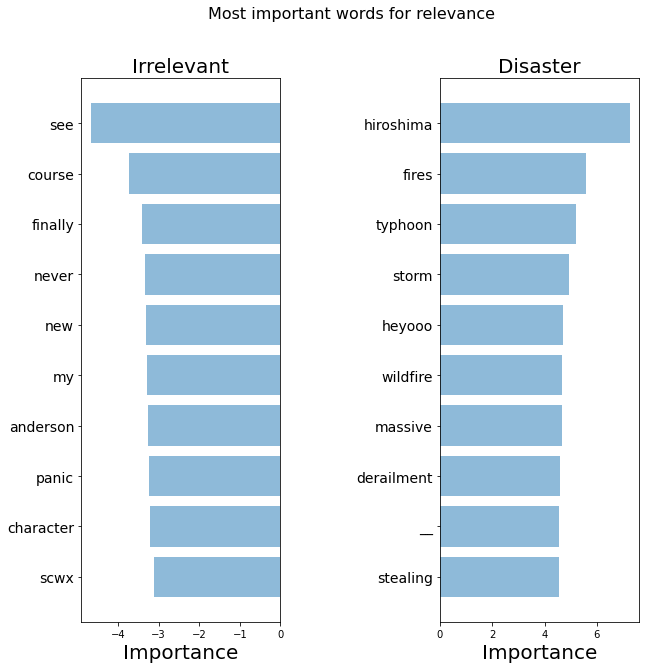

In [ ]:
top_scores = [a[0] for a in importance_tfidf[1]['tops']] 
top_words = [a[1] for a in importance_tfidf[1]['tops']] 
bottom_scores = [a[0] for a in importance_tfidf[1]['bottom']] 
bottom_words = [a[1] for a in importance_tfidf[1]['bottom']] 
plot_important_words(top_scores, top_words, bottom_scores, bottom_words, "Most important words for relevance")

Vemos que a ordem de relevância das palavras mudou bastante e que muitas palavras pouco relevantes para identificar os fatos foram descartadas. Sendo assim, podemos ter mais confiança nos resultados que obtivemos aqui e, também, que realmente obtivemos uma melhora em relação ao processo anterior, embora não tenha sido muito grande.

## Capturando o Significado Semântico das Palavras

Os dois primeiros modelos captam palavras de alta relevância. No entanto, é improvável que qualquer problema de NLP e ML apresente um conjunto de treinamento com todas as palavras realmente relevantes. Para resolver esse problema, é possível capturar o significado semântico das palavras. Ou seja, precisamos entender o grau de relação semântica que as palavras "bom"/"postivo" e "cereja"/"continente" apresentam entre si, por exemplo.

### Usando o Word2vec

O Word2vec é um modelo que foi pré-treinado com um conjunto de dados muito grande e fornece integrações que mapeiam palavras semanticamente relacionadas. Iremos trabalhar com a média das pontuações de similaridade de todas as palavras em nossas sentenças. A ideia da abordagem é que, quanto mais próximas semanticamente elas forem, mais próximo o peso delas será.

In [ ]:
import gensim

#Treinando a matriz de relação com notícias do Google 
#O conjunto de dados para treinar a matriz pode ser acessado em: #https://drive.google.com/file/d/0B7XkCwpI5KDYNlNUTTlSS21pQmM/edit 
word2vec_path = "/content/drive/MyDrive/bootcamp/GoogleNews-vectors-negative300.bin.gz" 
word2vec = gensim.models.KeyedVectors.load_word2vec_format(word2vec_path, binary=True)

In [ ]:
#Método para calcular a distância semântica entre as palavras 
def get_average_word2vec(tokens_list, vector, generate_missing=False, k=300):    
    if len(tokens_list)<1:        
       return np.zeros(k)    
    if generate_missing:        
       vectorized = [vector[word] if word in vector else np.random.rand(k) for word in tokens_list]    
    else:        
       vectorized = [vector[word] if word in vector else np.zeros(k) for word in tokens_list]    
    length = len(vectorized)    
    summed = np.sum(vectorized, axis=0)    
    averaged = np.divide(summed, length)    
    return averaged

#Montagem do arquivo de treinamento contento a relação semântica entre as palavras 
def get_word2vec_embeddings(vectors, clean_questions, generate_missing=False):    
    embeddings = clean_questions['tokens'].apply(lambda x: get_average_word2vec(x, vectors,generate_missing=generate_missing))    
    return list(embeddings)

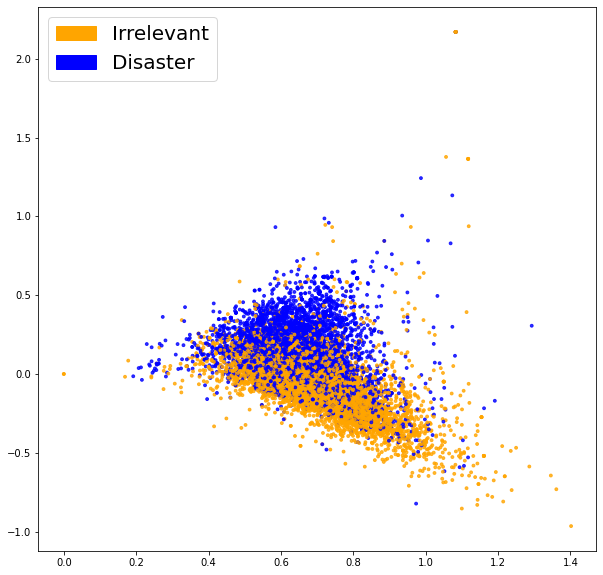

In [ ]:
embeddings = get_word2vec_embeddings(word2vec, clean_questions) 
X_train_word2vec, X_test_word2vec, y_train_word2vec, y_test_word2vec = train_test_split(embeddings, list_labels,test_size=0.2, random_state=40) 
fig = plt.figure(figsize=(10, 10))          
plot_LSA(embeddings, list_labels)
plt.show()

Como podemos obervar, nosso vocabulário parece ter sido melhor separado agora. Para os termos com pesos positivos a tendência é ele ser discriminatório para a classe positiva, para os termos com pesos negativos a tendência se inverte. Vamos ver como nosso modelo se comporta agora.



In [ ]:
clf_w2v = LogisticRegression(C=30.0, class_weight='balanced', solver='newton-cg',multi_class='multinomial', random_state=40) 
clf_w2v.fit(X_train_word2vec, y_train_word2vec) 
y_predicted_word2vec = clf_w2v.predict(X_test_word2vec)

In [ ]:
accuracy_word2vec, precision_word2vec, recall_word2vec, f1_word2vec = get_metrics(y_test_word2vec, y_predicted_word2vec) 
print("accuracy = %.3f, precision = %.3f, recall = %.3f, f1 = %.3f" % (accuracy_word2vec, precision_word2vec,recall_word2vec, f1_word2vec))

accuracy = 0.772, precision = 0.772, recall = 0.772, f1 = 0.772


Analisando as métricas, continuamos melhorando o poder de tomada de decisão do modelo.

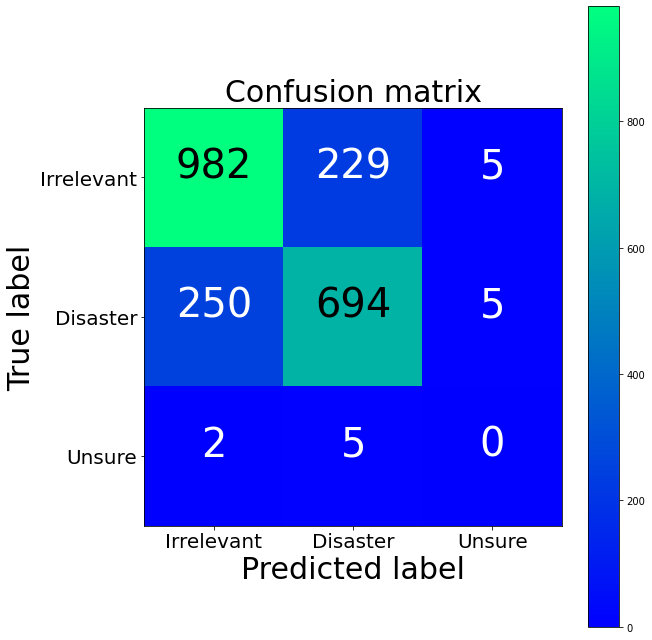

Word2Vec confusion matrix
[[982 229   5]
 [250 694   5]
 [  2   5   0]]
TFIDF confusion matrix
[[966 250   0]
 [265 684   0]
 [  3   4   0]]
BoW confusion matrix
[[975 240   1]
 [272 677   0]
 [  3   4   0]]


In [ ]:
cm_w2v = confusion_matrix(y_test_word2vec, y_predicted_word2vec) 
fig = plt.figure(figsize=(9, 9)) 
plot = plot_confusion_matrix(cm_w2v, classes=['Irrelevant','Disaster','Unsure'], normalize=False, title='Confusion matrix')
plt.show() 
print("Word2Vec confusion matrix") 
print(cm_w2v) 
print("TFIDF confusion matrix")
print(cm2) 
print("BoW confusion matrix") 
print(cm)

# Tokenização e segmentação de sentenças

A tokenização e a segmentação da palavras podem ser realizadas com a lib Stanza, as quais são executadas em conjunto pelo TokenizeProcessor. Este processador divide o texto de entrada  em tokens e frases. Este processador pode ser chamado pela função tokenize.

Nome | Nome da Classe | pré-requisito | Resumo | Descrição |
-------------------|------------------|------------------|------------------|------------------
tokenize       | TokenizeProcessor | - | Segmenta um documento em sentenças | Tokeniza o texto e realiza 
               |                   |   | gerando uma lista de Tokens. Este  | a segmentação de sentenças.
               |                   |   | processo também detecta palavras   |
               |                   |   | compostas que representam um token |
               |                   |   | com a utilização de MWTProcessor.  |

## Opções

A seguir,  algumas configurações para configuração do TokenizeProcessor :

Nome                 | Type | Default | Descrição                                            |
---------------------|------|---------|------------------------------------------------------
tokenize_batch_size  | int  |   32    | Este argumento especifica o número de parágrafos 
                     |      |         | a serem anlalisados em uma batelada de processamento.   
tokenize_pretokenized| bool | False   | Se o processamento for realizado com um texto já   
                     |      |         | tokenizado, colocar True.
tokenize_no_ssplit   | bool | False   | Não processa a segmentação, somente tokenização.  

## Exemplo de Usabilidade

A utilização do TokenizeProcessor  geralmente é a primeira etapa do processo.  Após essa aplicação, o documento se torna uma lista de tokens e sentenças. Em cada lista de sentença é possível acessar os tokens individualmente.Tokenization and Sentence Segmentation

A seguir um exemplo deste processamento:



In [ ]:
!pip install stanza

     |████████████████████████████████| 574 kB 4.1 MB/s 
     |████████████████████████████████| 4.0 MB 54.9 MB/s 
     |████████████████████████████████| 175 kB 70.6 MB/s 
     |████████████████████████████████| 895 kB 54.2 MB/s 
     |████████████████████████████████| 6.6 MB 36.9 MB/s 
     |████████████████████████████████| 596 kB 74.8 MB/s 
     |████████████████████████████████| 77 kB 6.9 MB/s 
  Created wheel for emoji: filename=emoji-1.7.0-py3-none-any.whl size=171046 sha256=0b4e51bb27f427d41c8e95840054170465d58a5abc0233ad89d6dcd7ef442991
  Stored in directory: /root/.cache/pip/wheels/8a/4e/b6/57b01db010d17ef6ea9b40300af725ef3e210cb1acfb7ac8b6
Successfully built emoji
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [ ]:
import stanza 

nlp = stanza.Pipeline(lang='en', processors='tokenize') 
doc = nlp('This is a test sentence for stanza. This is another sentence.') 
for i, sentence in enumerate(doc.sentences):     
    print(f'====== Sentence {i+1} tokens =======')     
    print(*[f'id: {token.id}\ttext: {token.text}' for token in sentence.tokens], sep='\n')

2022-04-28 01:05:45 INFO: Loading these models for language: en (English):
| Processor | Package  |
------------------------
| tokenize  | combined |

2022-04-28 01:05:45 INFO: Use device: cpu
2022-04-28 01:05:45 INFO: Loading: tokenize
2022-04-28 01:05:45 INFO: Done loading processors!


====== Sentence 1 tokens =======
id: (1,)	text: This
id: (2,)	text: is
id: (3,)	text: a
id: (4,)	text: test
id: (5,)	text: sentence
id: (6,)	text: for
id: (7,)	text: stanza
id: (8,)	text: .
====== Sentence 2 tokens =======
id: (1,)	text: This
id: (2,)	text: is
id: (3,)	text: another
id: (4,)	text: sentence
id: (5,)	text: .


Para acessar somente a segmentação de sentenças é possível fazendo:

In [ ]:
print([sentence.text for sentence in doc.sentences])

['This is a test sentence for stanza.', 'This is another sentence.']


## Tokenização sem Segmentação de Sentença



In [ ]:
import stanza

nlp = stanza.Pipeline(lang='en', processors='tokenize', tokenize_no_ssplit=True)
doc = nlp('This is a sentence.\n\nThis is a second. This is a third.')
for i, sentence in enumerate(doc.sentences):
    print(f'====== Sentence {i+1} tokens =======')
    print(*[f'id: {token.id}\ttext: {token.text}' for token in sentence.tokens], sep='\n')

2022-04-28 01:05:45 INFO: Loading these models for language: en (English):
| Processor | Package  |
------------------------
| tokenize  | combined |

2022-04-28 01:05:45 INFO: Use device: cpu
2022-04-28 01:05:45 INFO: Loading: tokenize
2022-04-28 01:05:45 INFO: Done loading processors!


====== Sentence 1 tokens =======
id: (1,)	text: This
id: (2,)	text: is
id: (3,)	text: a
id: (4,)	text: sentence
id: (5,)	text: .
====== Sentence 2 tokens =======
id: (1,)	text: This
id: (2,)	text: is
id: (3,)	text: a
id: (4,)	text: second
id: (5,)	text: .
id: (6,)	text: This
id: (7,)	text: is
id: (8,)	text: a
id: (9,)	text: third
id: (10,)	text: .


## Processar texto pré-tokenizado

Em alguns casos o texto pode está já tokenizado. Neste caso, é possível utilziar somente a segmentação de sentenças, bata  setar  tokenize_pretokenized como  True:

In [ ]:
import stanza
nlp = stanza.Pipeline(lang='en', processors='tokenize', tokenize_pretokenized=True)
doc = nlp('This is token.ization done my way!\nSentence split, too!')
for i, sentence in enumerate(doc.sentences):
    print(f'====== Sentence {i+1} tokens =======')
    print(*[f'id: {token.id}\ttext: {token.text}' for token in sentence.tokens], sep='\n')

2022-04-28 01:05:45 INFO: Loading these models for language: en (English):
| Processor | Package  |
------------------------
| tokenize  | combined |

2022-04-28 01:05:45 INFO: Use device: cpu
2022-04-28 01:05:45 INFO: Loading: tokenize
2022-04-28 01:05:45 INFO: Done loading processors!


====== Sentence 1 tokens =======
id: (1,)	text: This
id: (2,)	text: is
id: (3,)	text: token.ization
id: (4,)	text: done
id: (5,)	text: my
id: (6,)	text: way!
====== Sentence 2 tokens =======
id: (1,)	text: Sentence
id: (2,)	text: split,
id: (3,)	text: too!


Um alternativa é utilziar uma lista de stings:

In [ ]:
import stanza
nlp = stanza.Pipeline(lang='en', processors='tokenize', tokenize_pretokenized=True)
doc = nlp([['This', 'is', 'token.ization', 'done', 'my', 'way!'], ['Sentence', 'split,', 'too!']])
for i, sentence in enumerate(doc.sentences):
    print(f'====== Sentence {i+1} tokens =======')
    print(*[f'id: {token.id}\ttext: {token.text}' for token in sentence.tokens], sep='\n')

2022-04-28 01:05:46 INFO: Loading these models for language: en (English):
| Processor | Package  |
------------------------
| tokenize  | combined |

2022-04-28 01:05:46 INFO: Use device: cpu
2022-04-28 01:05:46 INFO: Loading: tokenize
2022-04-28 01:05:46 INFO: Done loading processors!


====== Sentence 1 tokens =======
id: (1,)	text: This
id: (2,)	text: is
id: (3,)	text: token.ization
id: (4,)	text: done
id: (5,)	text: my
id: (6,)	text: way!
====== Sentence 2 tokens =======
id: (1,)	text: Sentence
id: (2,)	text: split,
id: (3,)	text: too!


# Lematização

Tem como objetivo reduzir uma palavra à sua forma base e agrupar diferentes formas da mesma palavra. Por exemplo, os verbos no tempo passado são alterados para presente (por exemplo, “foi” é alterado para “vai”) e os sinônimos são unificados (por exemplo, “melhor” é alterado para “bom”), padronizando palavras com significado semelhante à sua raiz.   

A lematização resolve as palavras em sua forma de dicionário (conhecida como lema), para a qual requer dicionários detalhados nos quais o algoritmo pode pesquisar e vincular palavras aos lemas correspondentes.  

Por exemplo, as palavras “correr", "corre" e "correu" são todas formas da palavra "correr", portanto "correr" é o lema de todas as palavras anteriores.  

A lematização também leva em consideração o contexto da palavra para resolver outros problemas, como a desambiguação, o que significa que ela pode discriminar entre palavras idênticas que têm significados diferentes, dependendo do contexto específico. Pense em palavras como “morcego” (que pode corresponder ao animal ou ao clube de “banco”. Ao fornecer um parâmetro de parte do discurso para uma palavra (seja um substantivo, um verbo etc.), é possível definir um papel para essa palavra na frase e remover a desambiguação.

A implementação deste processo pode ser realizado com a lib stanza.  O módulo de lematização retorna a forma do lema para cada palavra de entrada. Por exemplo, a sequência de entrada “Eu comi uma maçã” será lematizada em “Eu como uma maçã”. Esse tipo de normalização de palavras é útil em muitos aplicativos do mundo real. Na Stanza, a lematização é realizada pelo LemmaProcessor .

## Exemplo de utilização

In [ ]:
import stanza
nlp = stanza.Pipeline(lang='en', processors='tokenize,mwt,pos,lemma')
doc = nlp('Barack Obama was born in Hawaii.')
print(*[f'word: {word.text+" "}\tlemma: {word.lemma}' for sent in doc.sentences for word in sent.words], sep='\n')

2022-04-28 01:05:46 WARNING: Can not find mwt: default from official model list. Ignoring it.


2022-04-28 01:05:51 INFO: Loading these models for language: en (English):
| Processor | Package  |
------------------------
| tokenize  | combined |
| pos       | combined |
| lemma     | combined |

2022-04-28 01:05:51 INFO: Use device: cpu
2022-04-28 01:05:51 INFO: Loading: tokenize
2022-04-28 01:05:51 INFO: Loading: pos
2022-04-28 01:05:51 INFO: Loading: lemma
2022-04-28 01:05:52 INFO: Done loading processors!


word: Barack 	lemma: Barack
word: Obama 	lemma: Obama
word: was 	lemma: be
word: born 	lemma: bear
word: in 	lemma: in
word: Hawaii 	lemma: Hawaii
word: . 	lemma: .


# Análise de sentimentos com NLTK

## Etapa 1 - Instalando o NLTK e baixando os dados

Você usará o pacote NLTK no Python para todas as tarefas NLP neste tutorial. Nesta etapa, você instalará o NLTK e fará o download dos tweets de amostra que você usará para treinar e testar seu modelo.

Primeiro, instale o pacote NLTK com o pipgerenciador de pacotes:

* pip install nltk==3.3

Este tutorial usará exemplos de tweets que fazem parte do pacote NLTK. Primeiro, inicie uma sessão interativa Python executando o seguinte comando:

* python3

Em seguida, importe o nltkmódulo no interpretador python.

* import nltk

Faça o download dos tweets de amostra do pacote NLTK:

* nltk.download('twitter_samples')

A execução desse comando no interpretador Python baixa e armazena os tweets localmente. Depois que as amostras são baixadas, elas ficam disponíveis para seu uso.

Você usará os tweets negativos e positivos para treinar seu modelo na análise de sentimentos posteriormente no tutorial. Os tweets sem sentimentos serão usados para testar seu modelo.

Se você quiser usar seu próprio conjunto de dados, poderá coletar tweets de um período, usuário ou hashtag específico usando a API do Twitter .

Agora que você importou NLTK e baixado os tweets de amostra, saia da sessão interativa inserindo nos exit(). Você está pronto para importar os tweets e começar a processar os dados.

In [ ]:
!pip install nltk==3.3

     |████████████████████████████████| 1.4 MB 4.5 MB/s 
  Created wheel for nltk: filename=nltk-3.3-py3-none-any.whl size=1394483 sha256=8f4c840c0adda55e24577a48309b85d91d786fbddf9102f717318fbfc52bc15c
  Stored in directory: /root/.cache/pip/wheels/9b/fd/0c/d92302c876e5de87ebd7fc0979d82edb93e2d8d768bf71fac4
Successfully built nltk
  Attempting uninstall: nltk
    Found existing installation: nltk 3.2.5
    Uninstalling nltk-3.2.5:
      Successfully uninstalled nltk-3.2.5


In [ ]:
import nltk

nltk.download('twitter_samples')

[nltk_data] Downloading package twitter_samples to /root/nltk_data...
[nltk_data]   Unzipping corpora/twitter_samples.zip.


True

## Etapa 2 - Tokenizando os Dados

O idioma em sua forma original não pode ser processado com precisão por uma máquina; portanto, você precisa processar o idioma para facilitar o entendimento da máquina. A primeira parte de entender os dados é através de um processo chamado tokenização , ou a divisão de strings em partes menores, chamadas tokens .

Um token é uma sequência de caracteres no texto que serve como uma unidade. Com base em como você cria os tokens, eles podem consistir em palavras, emoticons, hashtags, links ou até caracteres individuais. Uma maneira básica de dividir o idioma em tokens é dividir o texto com base em espaço em branco e pontuação.

Para começar, crie um novo .pyarquivo para armazenar seu script. Este tutorial usará nlp_test.py:

* nano nlp_test.py

Neste arquivo, você primeiro importará o arquivo twitter_samplespara poder trabalhar com esses dados:

nlp_test.py

In [ ]:
from nltk.corpus import twitter_samples

In [ ]:
from nltk.corpus import twitter_samples 
positive_tweets = twitter_samples.strings('positive_tweets.json')
negative_tweets = twitter_samples.strings('negative_tweets.json')
text = twitter_samples.strings('tweets.20150430-223406.json')

In [ ]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [ ]:
positive_tweets = twitter_samples.strings('positive_tweets.json')
negative_tweets = twitter_samples.strings('negative_tweets.json') 
text = twitter_samples.strings('tweets.20150430-223406.json')
tweet_tokens = twitter_samples.tokenized('positive_tweets.json')

In [ ]:
positive_tweets = twitter_samples.strings('positive_tweets.json')
negative_tweets = twitter_samples.strings('negative_tweets.json') 
text = twitter_samples.strings('tweets.20150430-223406.json') 
tweet_tokens = twitter_samples.tokenized('positive_tweets.json')[0]
print(tweet_tokens)

['#FollowFriday', '@France_Inte', '@PKuchly57', '@Milipol_Paris', 'for', 'being', 'top', 'engaged', 'members', 'in', 'my', 'community', 'this', 'week', ':)']


## Etapa 3 - Normalizando os dados

In [ ]:
import nltk
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


True

* NNP: Substantivo, próprio, singular
* NNSubstantivo, comum, singular ou de massa
* IN: Preposição ou conjunção, subordinação
* VBG: Partícula verbal, gerúndria ou presente
* VBN: Verbo, particípio passado

In [ ]:
from nltk.tag import pos_tag
from nltk.corpus import twitter_samples

tweet_tokens = twitter_samples.tokenized('positive_tweets.json')
print(pos_tag(tweet_tokens[0]))

[('#FollowFriday', 'JJ'), ('@France_Inte', 'NNP'), ('@PKuchly57', 'NNP'), ('@Milipol_Paris', 'NNP'), ('for', 'IN'), ('being', 'VBG'), ('top', 'JJ'), ('engaged', 'VBN'), ('members', 'NNS'), ('in', 'IN'), ('my', 'PRP$'), ('community', 'NN'), ('this', 'DT'), ('week', 'NN'), (':)', 'NN')]


In [ ]:
from nltk.stem.wordnet import WordNetLemmatizer 
def lemmatize_sentence(tokens):
    lemmatizer = WordNetLemmatizer()
    lemmatized_sentence = []    
    for word, tag in pos_tag(tokens):
        if tag.startswith('NN'):
            pos = 'n'
        elif tag.startswith('VB'):
            pos = 'v'
        else:
            pos = 'a'
        lemmatized_sentence.append(lemmatizer.lemmatize(word, pos))
    return lemmatized_sentence 
print(lemmatize_sentence(tweet_tokens[0]))

['#FollowFriday', '@France_Inte', '@PKuchly57', '@Milipol_Paris', 'for', 'be', 'top', 'engage', 'member', 'in', 'my', 'community', 'this', 'week', ':)']


## Etapa 4 - Removendo o ruído dos dados

Nesta etapa será removido o ruído do conjunto de dados. Ruído é qualquer parte do texto que não adiciona significado ou informação aos dados.

In [ ]:
import re, string 

def remove_noise(tweet_tokens, stop_words = ()):
    cleaned_tokens = []
    for token, tag in pos_tag(tweet_tokens):
        token = re.sub('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+#]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+','', token)
        token = re.sub("(@[A-Za-z0-9_]+)","", token)
        if tag.startswith("NN"):
            pos = 'n'
        elif tag.startswith('VB'):
            pos = 'v'
        else:
            pos = 'a'
        lemmatizer = WordNetLemmatizer()
        token = lemmatizer.lemmatize(token, pos)
        if len(token) > 0 and token not in string.punctuation and token.lower() not in stop_words:
            cleaned_tokens.append(token.lower())
    return cleaned_tokens

In [ ]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
from nltk.corpus import stopwords
stop_words = stopwords.words('english') 
print(remove_noise(tweet_tokens[0], stop_words))

['#followfriday', 'top', 'engage', 'member', 'community', 'week', ':)']


In [ ]:
stop_words = stopwords.words('english') 
#print(remove_noise(tweet_tokens[0], stop_words)) 
positive_tweet_tokens = twitter_samples.tokenized('positive_tweets.json')
negative_tweet_tokens = twitter_samples.tokenized('negative_tweets.json')
positive_cleaned_tokens_list = []
negative_cleaned_tokens_list = []
for tokens in positive_tweet_tokens:
    positive_cleaned_tokens_list.append(remove_noise(tokens, stop_words))
for tokens in negative_tweet_tokens:
    negative_cleaned_tokens_list.append(remove_noise(tokens, stop_words))

In [ ]:
print(positive_tweet_tokens[500]) 
print(positive_cleaned_tokens_list[500])

['Dang', 'that', 'is', 'some', 'rad', '@AbzuGame', '#fanart', '!', ':D', 'https://t.co/bI8k8tb9ht']
['dang', 'rad', '#fanart', ':d']


## Etapa 5 - Determinando a densidade da palavra

A forma mais básica de análise de dados textuais é retirar a palavra frequência. Um único tweet é uma entidade muito pequena para descobrir a distribuição das palavras; portanto, a análise da frequência das palavras seria feita em todos os tweets positivos.

O fragmento a seguir define uma função geradora , chamada get_all_words, que recebe uma lista de tweets como argumento para fornecer uma lista de palavras em todos os tokens de tweet associados.

In [ ]:
def get_all_words(cleaned_tokens_list):
    for tokens in cleaned_tokens_list:
        for token in tokens:
            yield token 
all_pos_words = get_all_words(positive_cleaned_tokens_list)

In [ ]:
from nltk import FreqDist 
freq_dist_pos = FreqDist(all_pos_words)
print(freq_dist_pos.most_common(10))

[(':)', 3691), (':-)', 701), (':d', 658), ('thanks', 388), ('follow', 357), ('love', 333), ('...', 290), ('good', 283), ('get', 263), ('thank', 253)]


## Etapa 6 - Preparando dados para o modelo

A análise de sentimentos é um processo de identificação de uma atitude do autor sobre um tópico sobre o qual está sendo escrito. Você criará um conjunto de dados de treinamento para treinar um modelo. É um processo de aprendizado de máquina de aprendizado supervisionado, que exige que você associe cada conjunto de dados a um "sentimento" de treinamento. Neste tutorial, seu modelo usará os sentimentos "positivo" e "negativo".

Um modelo é uma descrição de um sistema usando regras e equações. Pode ser tão simples quanto uma equação que prevê o peso de uma pessoa, dada a sua altura. Um modelo de análise de sentimentos que você criará associaria os tweets a um sentimento positivo ou negativo. Você precisará dividir seu conjunto de dados em duas partes. O objetivo da primeira parte é construir o modelo, enquanto a próxima parte testa o desempenho do modelo.

### Convertendo tokens em um dicionário

In [ ]:
def get_tweets_for_model(cleaned_tokens_list):
    for tweet_tokens in cleaned_tokens_list:
        yield dict([token, True] for token in tweet_tokens) 
positive_tokens_for_model = get_tweets_for_model(positive_cleaned_tokens_list)
negative_tokens_for_model = get_tweets_for_model(negative_cleaned_tokens_list)

### Divisão do conjunto de dados para treinamento e teste do modelo

In [ ]:
import random 
positive_dataset = [(tweet_dict, "Positive")for tweet_dict in positive_tokens_for_model] 
negative_dataset = [(tweet_dict, "Negative")for tweet_dict in negative_tokens_for_model] 
dataset = positive_dataset + negative_dataset 
random.shuffle(dataset) 
train_data = dataset[:7000]
test_data = dataset[7000:]

## Etapa 7 - Criando e testando o modelo

In [ ]:
from nltk import classify
from nltk import NaiveBayesClassifier
classifier = NaiveBayesClassifier.train(train_data) 
print("Accuracy is:", classify.accuracy(classifier, test_data)) 
print(classifier.show_most_informative_features(10))

Accuracy is: 0.994
Most Informative Features
                      :) = True           Positi : Negati =   1661.5 : 1.0
                follower = True           Positi : Negati =     23.1 : 1.0
                followed = True           Negati : Positi =     22.9 : 1.0
                     sad = True           Negati : Positi =     19.1 : 1.0
                     bam = True           Positi : Negati =     19.1 : 1.0
                     x15 = True           Negati : Positi =     16.2 : 1.0
                  arrive = True           Positi : Negati =     14.5 : 1.0
              appreciate = True           Positi : Negati =     14.4 : 1.0
                    cool = True           Positi : Negati =     12.3 : 1.0
                    glad = True           Positi : Negati =     11.5 : 1.0
None


 precisão é definida como a porcentagem de tweets no conjunto de dados de teste para o qual o modelo foi capaz de prever corretamente o sentimento. Uma precisão de 99,4% no conjunto de testes é muito boa.

In [ ]:
from nltk.tokenize import word_tokenize 
custom_tweet = "I ordered just once from TerribleCo, they screwed up, never used the app again."
custom_tokens = remove_noise(word_tokenize(custom_tweet)) 
print(classifier.classify(dict([token, True] for token in custom_tokens)))

Negative


In [ ]:
custom_tweet = 'Congrats #SportStar on your 7th best goal from last season winning goal of the year :) #Baller #Topbin #oneofmanyworldies'
custom_tokens = remove_noise(word_tokenize(custom_tweet)) 
print(classifier.classify(dict([token, True] for token in custom_tokens)))

Positive


In [ ]:
from nltk.tokenize import word_tokenize 
custom_tweet = "I ordered just once from TerribleCo, they screwed up gain." 
custom_tokens = remove_noise(word_tokenize(custom_tweet)) 
print(classifier.classify(dict([token, True] for token in custom_tokens)))

Positive
